# Overview 

This study involves the use of Anomaly Detection to detect defects in Additively Manufactured Titanium (Ti-6Al-4V) medical lattice structures. 

For this study, 5 different lattice structures were 3D printed, with an intentional drop in Laser Power at known layers. This resulted in microstructural defects being produced in the components, which in introduced variations in the In-Process data. An unintentional mechanical defect introduced by a wiper tearing a lattice was also observed. The purpose of this study, is to examine the capabilities of the Generalised Extreme Studentized Deviate (GESD) test, to detect this mechanical defect in the data. The effect of signal processing effects will also be observed.

The data for this experiment was gathered by the Renishaw InfiniAM in-process monitoring system. This system monitors spectral emmissions in the powder bed upon melting accross a wide spectral range using photo-diodes. This results in 3 features per diode for every x,y position accross each layer in the build. Each spectral emmission feature corresponds to the intensity of the light within that diodes detection range. See the below format for the data (Note that only 2 of the diodes monitor spectral emmissions in the material, while the third LASERVIEW diode monitors the lasers input) : 
16

| X-Position | Y-Position | IR Diode | Plasma Diode | LaserVIEW Diode |
| --- | --- | --- | --- | --- |
| 5 | 10 | 1234 | 4332 | 3232 | 

More information on the GESD and Renishaw system can be found at: 

https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm

https://www.renishaw.com/en/infiniam-central--39816

## Importing neccessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import ntpath
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator

## Importing the Data for each of the 5 samples

In [2]:
## Importing the per layer summary data for each lattice

#Now to read the excel files of each, skipping header line
BLDF = pd.read_csv(r'C:\Users\conor\Documents\Python\Masters Python Files\GESD\Porous Structures Layer Data\BL_DF.csv',index_col=0,header = None)
BRDF = pd.read_csv(r'C:\Users\conor\Documents\Python\Masters Python Files\GESD\Porous Structures Layer Data\BR_DF.csv',index_col=0,header = None)
TLDF = pd.read_csv(r'C:\Users\conor\Documents\Python\Masters Python Files\GESD\Porous Structures Layer Data\TL_df.csv',index_col=0,header = None)
TRDF = pd.read_csv(r'C:\Users\conor\Documents\Python\Masters Python Files\GESD\Porous Structures Layer Data\TR_DF.csv',index_col=0,header = None)
CENTRE = pd.read_csv(r'C:\Users\conor\Documents\Python\Masters Python Files\GESD\Porous Structures Layer Data\C_DFx.csv',index_col=0,header = None)

In [3]:
def indexer(list1):
 #   lol = []
    for item in list1:
        x = np.split(item, len(item))
        lol.extend(x)
    lolol = pd.DataFrame(lol)
    lolol = lolol[0].value_counts()
    x1 = lolol.index.tolist()
    return x1

## Defining Functions 

In [4]:
#Here we define a Path_Leaf function, which takes a file path as an argument, and returns the Filename from a Filepath
ntpath.basename("a/b/c")
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [5]:
#This function takes a CSV file, and column number as an argument. It then produces Dataframe column, based on the index provided, 
#and renames it based on the filepath using the Path_Leaf function. This function isolates columns corresponding to certain diodes 
def Mean_Signal(inputdata,columno):
    readfile = pd.read_csv(inputdata,index_col=0,header = None)
    x = pd.DataFrame(readfile[columno])
    y = x.rename(columns = {columno: 'Mean Signal %s' % path_leaf(inputdata)})
    return y

## Data Manipulation 

Each layer contains hundreds of thousands of x,y grid points, each with 3 different Diode readings for over 900 layers. In order to reduce the dataset, each layer was split into 5 sections. These sections corresponded to the Top Left, Top Right, Bottom Left, Bottom Right and Centre samples. The diode readings for each section were then averaged. So for a given layer, 5 sections contained 3 values. This reduced the dataset to 3 * 5 * 900 = 13500 datapoints compared to the millions that were initially being used. 

# Plan of Action 

So, for this mechanical defect we want to detect. We first want to see if there was any effect on the Diode sensor readings. We will not check the LaserVIEW diode, as this was a mechanically induced defect, not a laser induced defect. 

Using our already defined Mean_Signal function, we can collate the mean signal of each sensor, in each of the pieces accross all layers. We will first check the Infra Red Sensor. 

In [6]:
Section_List = ['BL_DF','TL_DF','BR_DF','TR_DF','C_DFx']
PD1 = pd.DataFrame()

for i in Section_List:
    Location = 'C:/Users/conor/Documents/Python/Masters Python Files/GESD/Porous Structures Layer Data/' + i + '.csv'
    PD1 = pd.concat([PD1,Mean_Signal(Location,3)], axis = 1)
PD1 = PD1.rename_axis('Layer ID' )
PD1.head(5)

,Mean Signal BL_DF.csv,Mean Signal TL_DF.csv,Mean Signal BR_DF.csv,Mean Signal TR_DF.csv,Mean Signal C_DFx.csv
Layer ID,,,,,
200,1283,1273,1278,1259,1315
201,1302,1286,1330,1270,1337
202,1385,1383,1430,1358,1464
203,1999,1997,1886,1899,2073
204,1295,1288,1284,1275,1333


We know that this defect occured in the Centre piece, and about 700 layers into the build. Therefore, we will compare the Centre piece IR signal in that region, against the average IR signals of the other pieces to see if there was anything interesting in the data. 

Text(0.5, 1.0, 'IR Diode Signal Analysis')

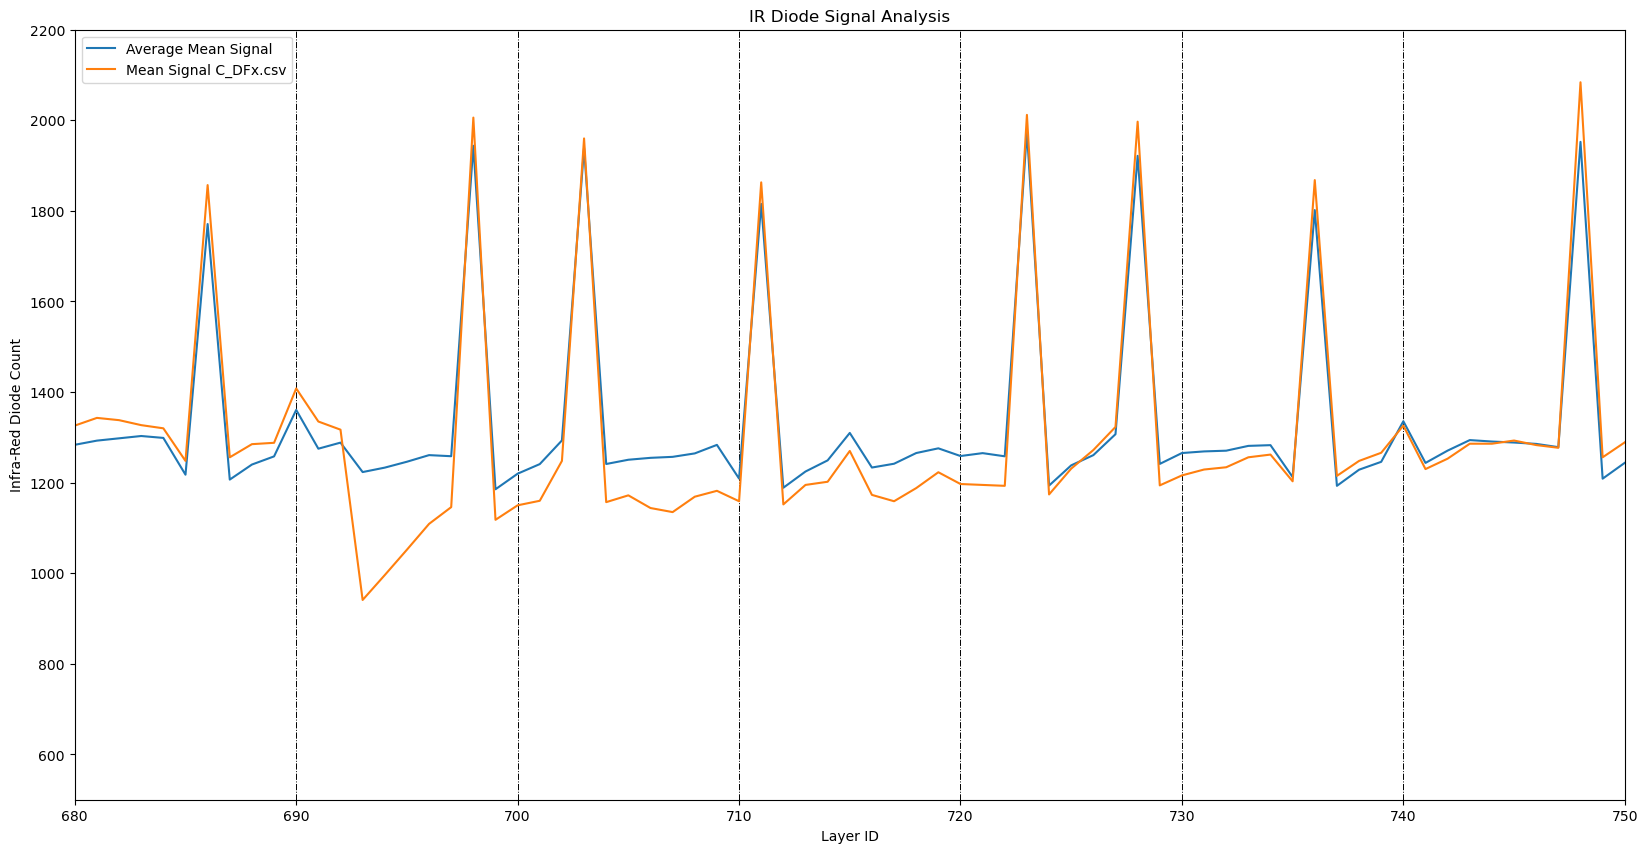

In [7]:
PD1['Average Mean Signal'] = PD1.mean(axis=1)
ax = plt.gca()
PD1.reset_index().plot(x='Layer ID', y=['Average Mean Signal', 'Mean Signal C_DFx.csv'], kind="line", ax= ax, figsize=(20,10))
ml = MultipleLocator(50)
ax.xaxis.set_minor_locator(ml)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
plt.axis([680,750,500,2200])
plt.ylabel('Infra-Red Diode Count')
plt.title('IR Diode Signal Analysis')

Holy smokes. around 690 odd layers in, we can see a drastic drop in the IR diode signal. That's our smoking gun. This is good, we have a noticeable affect on the data. Now, we'll check if we can see anything in the Plasma Diode data. 

In [8]:
PD2 = pd.DataFrame()
for i in Section_List:
    Location = 'C:/Users/conor/Documents/Python/Masters Python Files/GESD/Porous Structures Layer Data/' + i + '.csv'
    PD2 = pd.concat([PD2,Mean_Signal(Location,4)], axis = 1)
PD2 = PD2.rename_axis('Layer ID' )
PD2.head(5)

,Mean Signal BL_DF.csv,Mean Signal TL_DF.csv,Mean Signal BR_DF.csv,Mean Signal TR_DF.csv,Mean Signal C_DFx.csv
Layer ID,,,,,
200,236,242,268,271,270
201,242,248,276,277,277
202,255,262,289,287,292
203,376,388,428,436,438
204,242,248,272,279,278


Text(0.5, 1.0, 'Plasma Diode Signal Analysis')

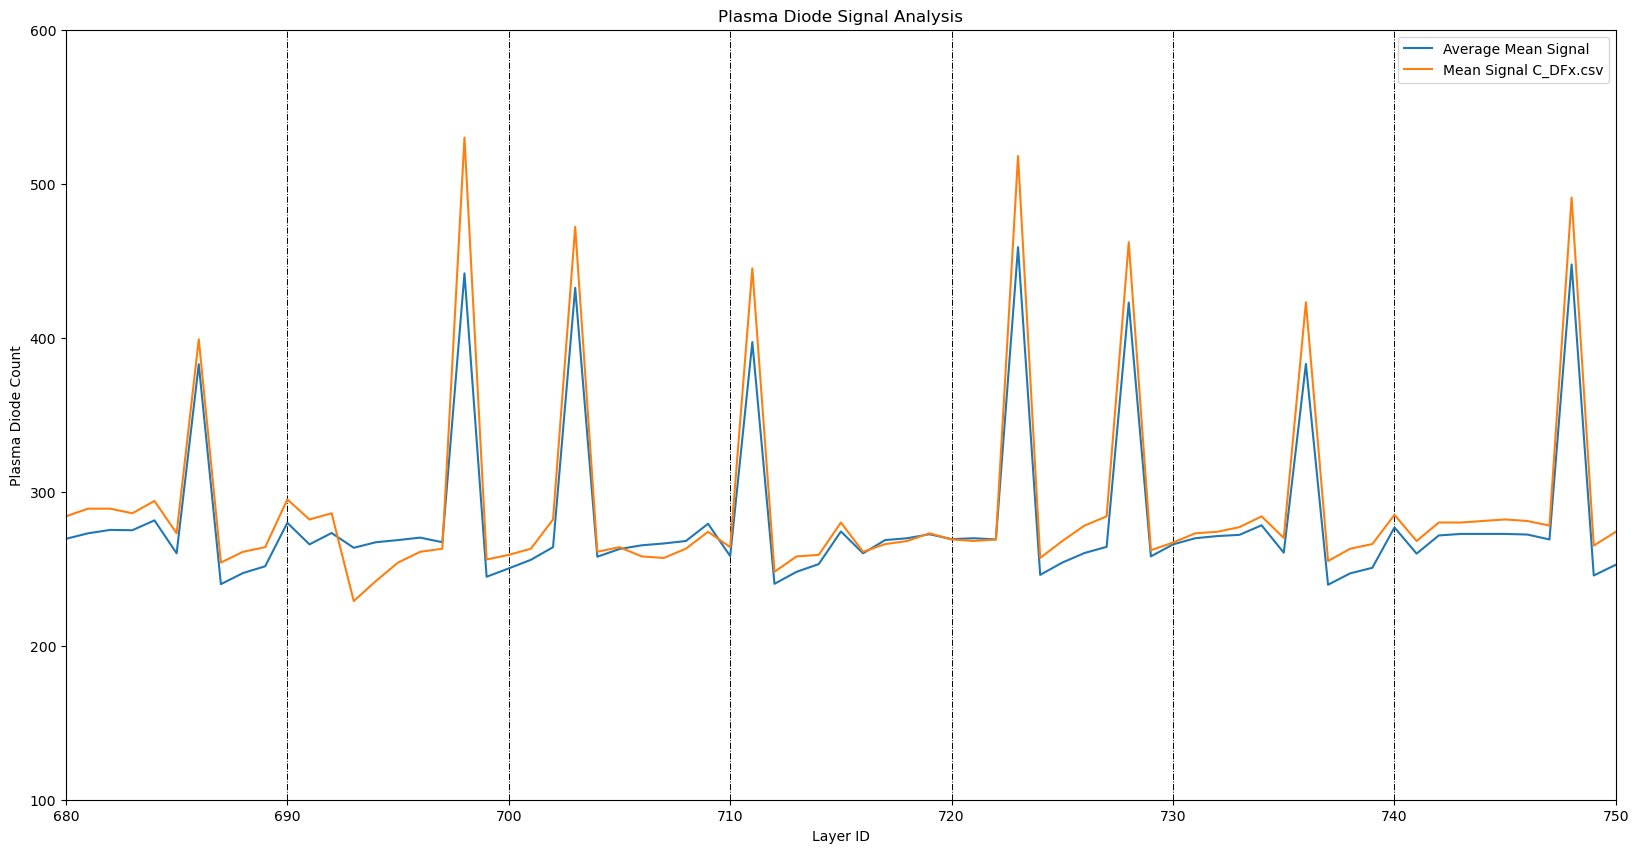

In [9]:
PD2['Average Mean Signal'] = PD2.mean(axis=1)
ax = plt.gca()
PD2.reset_index().plot(x='Layer ID', y=['Average Mean Signal', 'Mean Signal C_DFx.csv'], kind="line", ax= ax, figsize=(20,10))
ml = MultipleLocator(50)
ax.xaxis.set_minor_locator(ml)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
plt.axis([680,750,100,600])
plt.ylabel('Plasma Diode Count')
plt.title('Plasma Diode Signal Analysis')

I am a detective. There it is again, the same affect at about 690 layers in. The drop in signal in that piece relative to the average signal is common to both diodes. For the rest of this investigation, I'll only focus on the IR diode, as the affect is more pronounced in that spectral range.

Before we plow on ahead, I think we need another sconce at the data to plan ahead: 

Text(0.5, 1.0, 'IR Diode Signal Analysis')

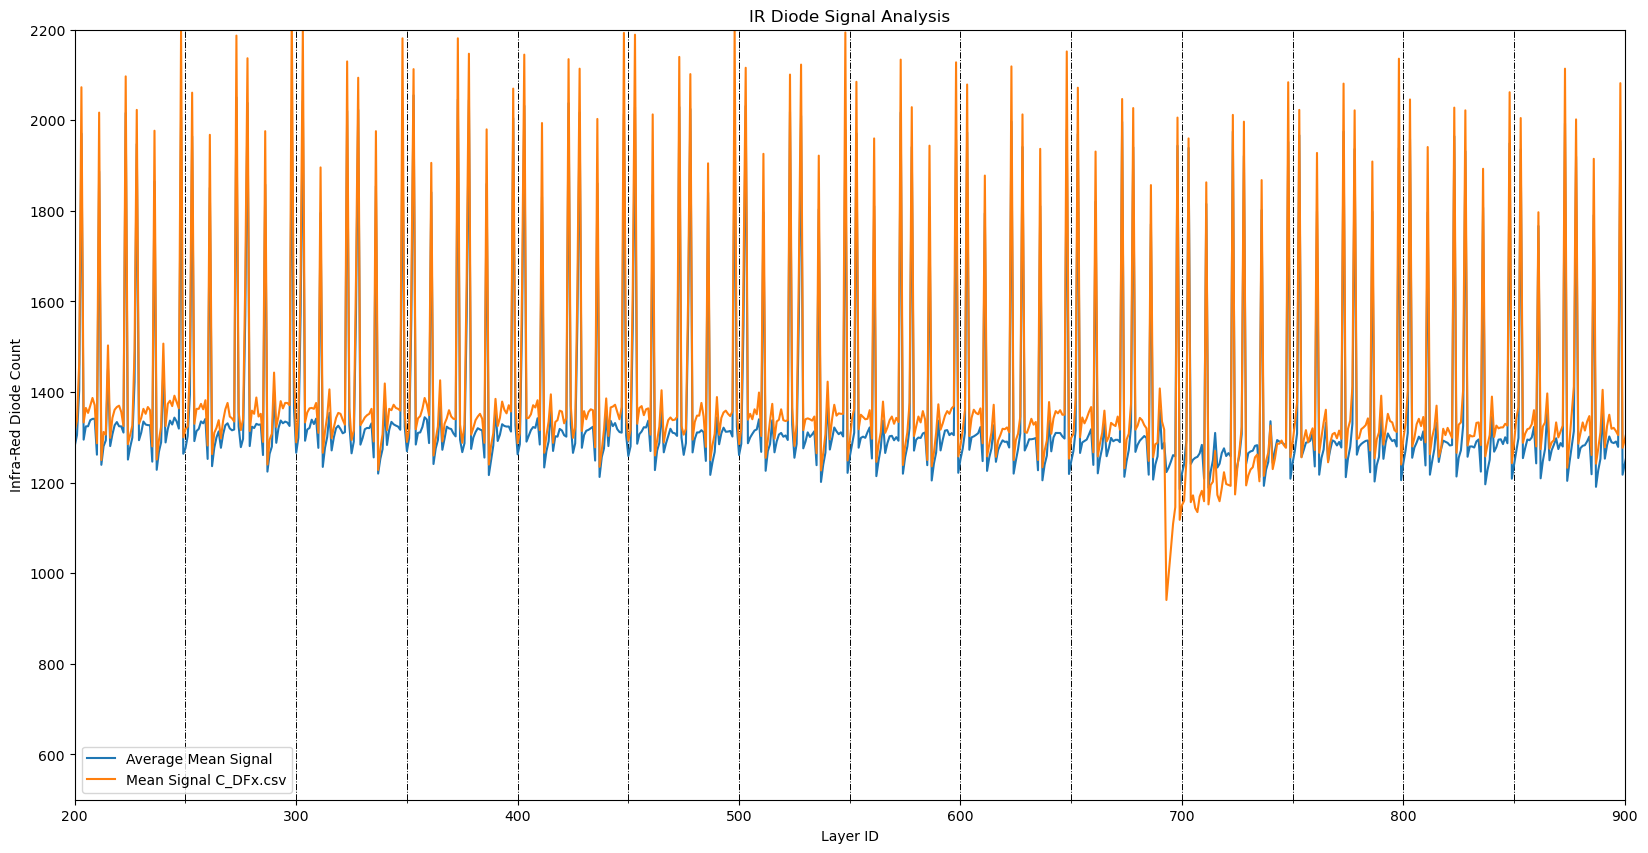

In [10]:
PD1['Average Mean Signal'] = PD1.mean(axis=1)
ax = plt.gca()
PD1.reset_index().plot(x='Layer ID', y=['Average Mean Signal', 'Mean Signal C_DFx.csv'], kind="line", ax= ax, figsize=(20,10))
ml = MultipleLocator(50)
ax.xaxis.set_minor_locator(ml)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
plt.axis([200,900,500,2200])
plt.ylabel('Infra-Red Diode Count')
plt.title('IR Diode Signal Analysis')

We can see above that although we have our drop in signal, we also consistently have a series of these peaks and troughs in the data. If we attempt to apply any sort of Anomaly Detection here, these peaks will cause mayhem. They'll either be detected as anomalies (which they're not) or they'll massively affect the variance, which is used in the calculation of Test Statistics in the GESD test. Therefore we need to apply some signal proccessing. 

As each piece was identical, and built using identical process parameters they should have the same IR data signal at each and every layer. So if we want to take a look at this signal drop in the Centre Piece C_Dfx, we should start by investigating how this drop looks compared to the Percentage Deviation of that signal from the above Blue Average Signal. 

In [11]:
PD1['Percentage Deviation'] = round((100*(PD1['Average Mean Signal'] - PD1['Mean Signal C_DFx.csv'])/PD1['Average Mean Signal']),3)
PD1.head(5)

,Mean Signal BL_DF.csv,Mean Signal TL_DF.csv,Mean Signal BR_DF.csv,Mean Signal TR_DF.csv,Mean Signal C_DFx.csv,Average Mean Signal,Percentage Deviation
Layer ID,,,,,,,
200,1283,1273,1278,1259,1315,1281.6,-2.606
201,1302,1286,1330,1270,1337,1305.0,-2.452
202,1385,1383,1430,1358,1464,1404.0,-4.274
203,1999,1997,1886,1899,2073,1970.8,-5.186
204,1295,1288,1284,1275,1333,1295.0,-2.934


Text(0.5, 1.0, 'Percent Deviation between Centre Sample and other Samples')

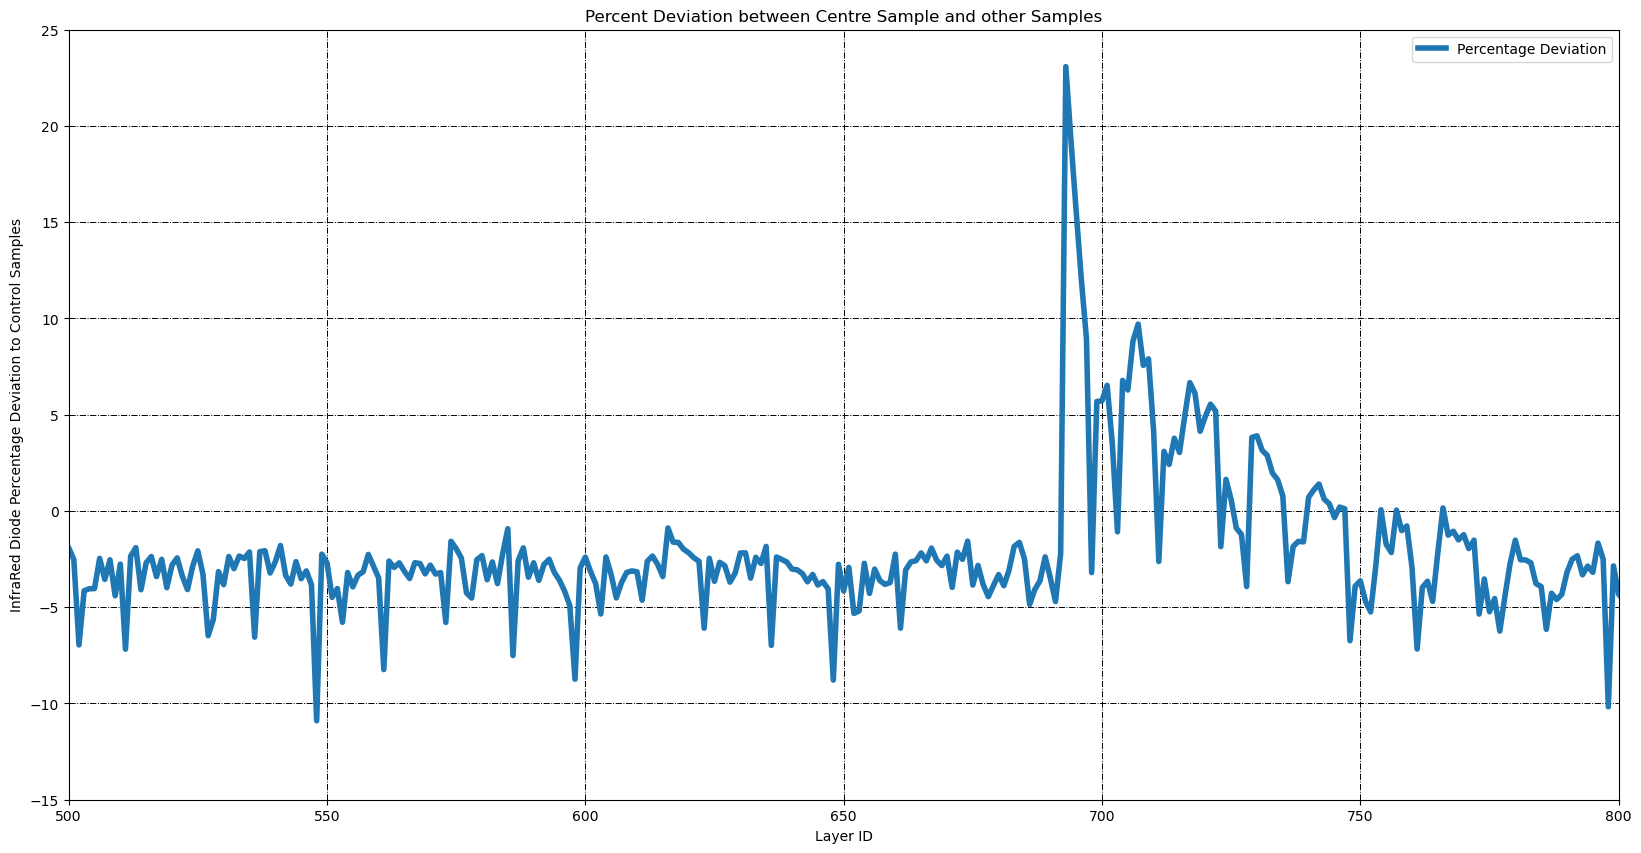

In [12]:
ax = plt.gca()
PD1.reset_index().plot(x='Layer ID', y=['Percentage Deviation'], kind="line", ax= ax, figsize=(20,10), linewidth  = 4 )
ml = MultipleLocator(50)
ml1 = MultipleLocator(10)
ax.xaxis.set_minor_locator(ml)
ax.yaxis.set_minor_locator(ml1)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
ax.yaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
plt.axis([500,800,-15,25])
plt.legend()
plt.ylabel('InfraRed Diode Percentage Deviation to Control Samples')
plt.title('Percent Deviation between Centre Sample and other Samples')

Great, this looks a bit better than before we still have some noise, but not as much. We also still see that drop in signal now manifesting as a sharp increase. We can also see the instant the tear in the material occurs, and the effect dopping off in an oscilating fashion. 

We need to apply some final signal processing before we apply Anomaly Detection. We must smoothen out the noise, therefore we are initially going to apply some averaging methods. We first will go with the Rolling Average. 

The RA does what it says on the tin, but it can be done in 2 ways. For example:

If a Window of width 3 is used, if the RA is set no 'Non-Centred', each point will be replaced with the average value of the preceding 2 points, as well as the value of the point in question. 

If a Centred Window is used, that point would be the average value of the point, and the values directly before and after it. 

We are going to use Centred rolling. This is to avoid the affect I will demonstrate below with a Window size of 10. 

Text(0.5, 1.0, 'Percent Deviation between Centre Sample and other Samples')

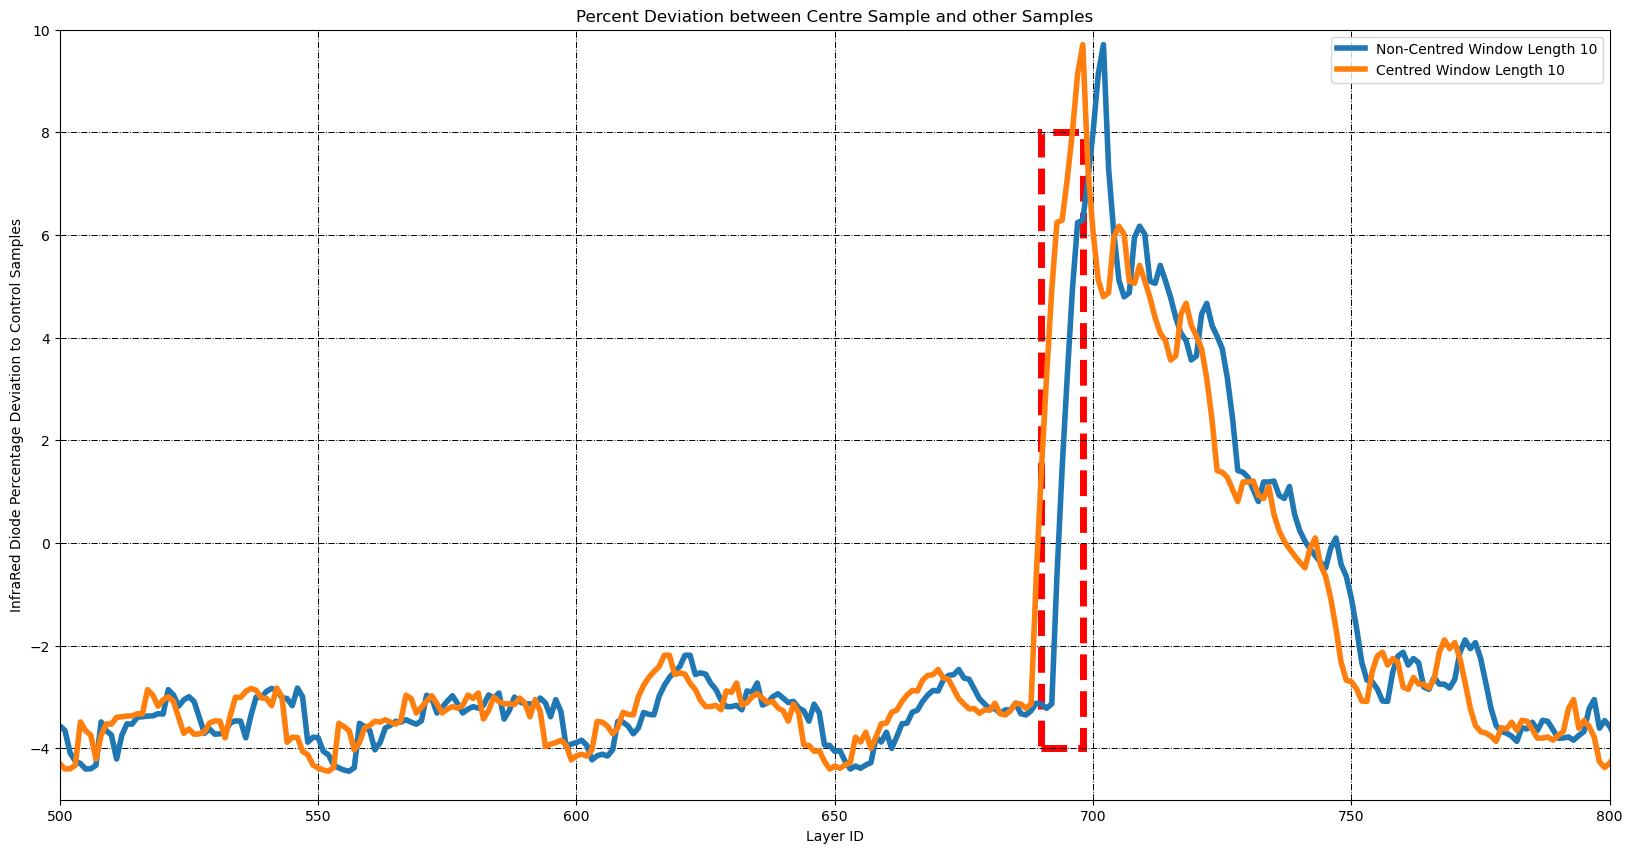

In [13]:
PD1['Non-Centred Window Length 10'] = PD1['Percentage Deviation'].rolling(10).mean()
PD1['Centred Window Length 10'] = PD1['Percentage Deviation'].rolling(10, center = True).mean()
ax = plt.gca()
PD1.reset_index().plot(x='Layer ID', y=['Non-Centred Window Length 10','Centred Window Length 10'], kind="line", ax= ax, figsize=(20,10), linewidth  = 4 )
ml = MultipleLocator(50)
ml1 = MultipleLocator(10)
ax.xaxis.set_minor_locator(ml)
ax.yaxis.set_minor_locator(ml1)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
ax.yaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
# Create a Rectangle patch
rect = patches.Rectangle((690, -4), 8, 12, linewidth=5, edgecolor='r', facecolor='none', linestyle = 'dashed')

# Add the patch to the Axes
ax.add_patch(rect)
plt.axis([500,800,-5,10])
plt.legend()
plt.ylabel('InfraRed Diode Percentage Deviation to Control Samples')
plt.title('Percent Deviation between Centre Sample and other Samples')

The area enclosed in the red dashed rectangle should correspond to the highest peak, however it has been removed entirely in the non centred window. This is due to these points including the values of the preceding5 or 6 layers or so, which occured before the wiper damage. We can see it is included in the centered window, and as this is the area where we most want to identify the defects, we'll use this method. 

"But Conor, how do we know what size window to use!?" - I hear you think.

We surely cant just use an arbitrary number, as this will affect the graph, as we can see below. 

Text(0.5, 1.0, 'Percent Deviation between Centre Sample and other Samples')

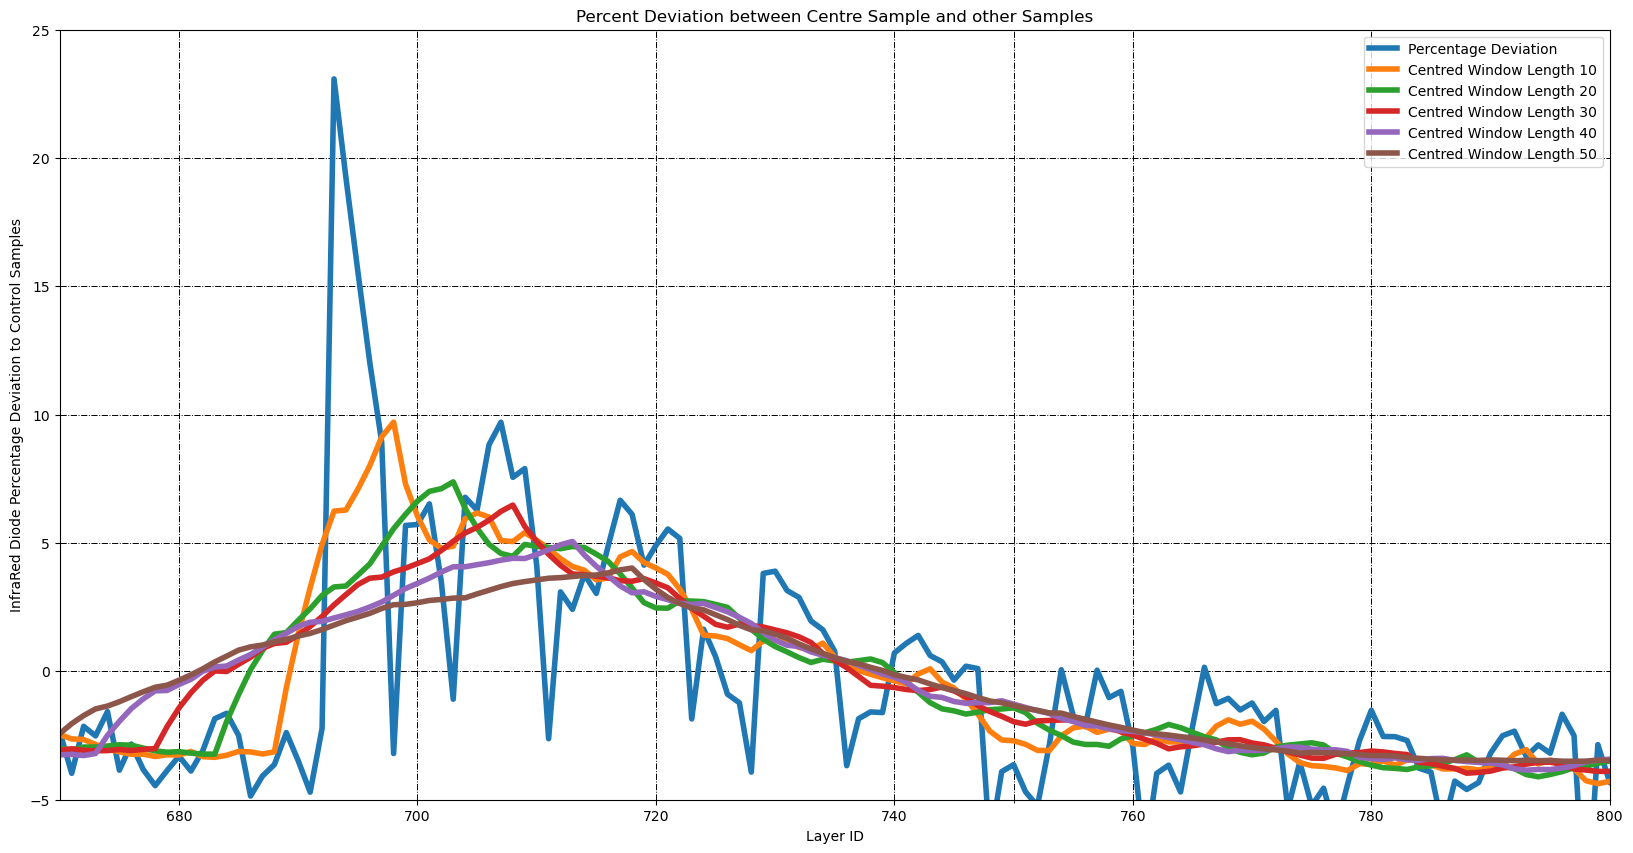

In [14]:
PD1['Centred Window Length 20'] = PD1['Percentage Deviation'].rolling(20, center = True).mean()
PD1['Centred Window Length 30'] = PD1['Percentage Deviation'].rolling(30, center = True).mean()
PD1['Centred Window Length 40'] = PD1['Percentage Deviation'].rolling(40, center = True).mean()
PD1['Centred Window Length 50'] = PD1['Percentage Deviation'].rolling(50, center = True).mean()
ax = plt.gca()
PD1.reset_index().plot(x='Layer ID', y=['Percentage Deviation','Centred Window Length 10','Centred Window Length 20','Centred Window Length 30','Centred Window Length 40','Centred Window Length 50'], kind="line", ax= ax, figsize=(20,10), linewidth  = 4 )
ml = MultipleLocator(50)
ml1 = MultipleLocator(10)
ax.xaxis.set_minor_locator(ml)
ax.yaxis.set_minor_locator(ml1)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
ax.yaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
plt.axis([670,800,-5,25])
plt.legend()
plt.ylabel('InfraRed Diode Percentage Deviation to Control Samples')
plt.title('Percent Deviation between Centre Sample and other Samples')

Oh my gosh this is so concerning. But we have a plan. Say we have a Window Size (WS) of 3, and we then detect say 20 anomalies. We then try a WS of 4 and detect 22 anomalies. We then go on so on and so forth until we get to a value, where the number of anomalies has not changed in 3 succesive WS increments. We can then say this WS is the one where the #Anomalies has converged to it's true value. 

So our POA is to increment WS until the #Anomalies remains consistent for 3 iterations. Cool beans. How the heck are we going to detect anomalies though? 

## Generalized Extreme Studentized Deviate (GESD) Test 

As we don't have a library with this test included in it (we might do, but I don't know of it) we're going to have to define this test ourselves using functions. Grim. 

What this test does: 

1 - For an array, assumed to be normally distributed, the value that differs most from the mean is used to calculate its Grubbs Stat. 
2 - The critical value for the array is calculated based on the length of the array, and significance level using a t-distribution. 
3 - If this values Grubbs stat is larger than the Critical Value, we say its an outlier. If not we don't. 

Steps 1 to 3 above are for a singular ESD test. A GESD test is essentially an iterative form of the above test, where we repeat it until we no longer have outliers in the array. 

4 - If an outlier is found, we remove it from the array and store it elsewhere. Wee then repeat 1 to 3 until no more outliers are present. 

In [15]:
#First, we define a function that takes an array as a parameter, and calculates the Grubbs Statistic for the most 'non-normal' element of that array
#Under the assumption that array is normally distributed
def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y) #Calculating Standard Deviation and Mean of the array
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg) #We then find the value, and corresponding index of the value that deviates most from that mean 
    Gcal = max_of_deviations/ std_dev #Grubbs stat is the max diff divided by standard dev 
    return Gcal, max_ind

In [16]:
def calculate_critical_value(size, alpha): 
    #Here we calculate the Critical Value. We use an alpha (significance level) value, and a degree of freedom. 
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)#Calculating the t distribution values
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    return critical_value

In [17]:
def check_G_values(Gs, Gc, inp, max_index, Grubbs_list): # Checking the Grubbs stat and critical values
    if Gs > Gc:
        Grubbs_list.append(inp[max_index])
    return Grubbs_list

In [18]:
def ESD_Test(input_series, alpha, max_outliers):# Iterating the Grubbs test 
    outlier_list = []
    ESD_list = []
    for iterations in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        check_G_values(Gstat, Gcritical, input_series, max_index, ESD_list)
        input_series = np.delete(input_series, max_index)
        if iterations == (max_outliers - 1):
            dummy = check_G_values(Gstat, Gcritical, input_series, max_index, ESD_list)
            outlier_list = dummy.copy()
    return outlier_list

So we're good to start detecting some outliers here. We are going to only use a significance level $\alpha$ = 0.05. 

In [19]:
testinglist = []
NDetected = []
Rollingavg = []
#Now to create a Dataframe for the WL of rolling average vs #defects detected
WLDataframe = pd.DataFrame()
Anomaly_Indices = {}
for i in range (1,30):
    testinglist.clear()
    RollingPerDevC = PD1['Percentage Deviation'].copy()
    RollingPerDevC = pd.DataFrame(RollingPerDevC)
    RollingPerDevC = RollingPerDevC.rolling(i , center = False).mean()
    RollingPerDevC = RollingPerDevC.dropna()
    array = RollingPerDevC['Percentage Deviation'].to_numpy()
    testinglist = ESD_Test(array, 0.05, 100)
    NDetected.append(len(testinglist))
    Rollingavg.append(i)
    ynew = []
    for z in testinglist:
        if z in RollingPerDevC.values:
            ynew.append(RollingPerDevC[RollingPerDevC['Percentage Deviation']== z ].index.values)
    DefectDataFramePer = pd.DataFrame(ynew, testinglist)
    Column_Name = 'PD Signal Outlier ' + str(i)
    Anomaly_Indices[Column_Name] = pd.Series(ynew).astype(int)
WLDataframe['Window Length'] = Rollingavg 
WLDataframe['Number of Detected Defects'] = NDetected
Anomaly_Indices = pd.DataFrame(Anomaly_Indices)
NDetected.clear()
Rollingavg.clear()
WLDataframe.head(5)

,Window Length,Number of Detected Defects
0,1,34
1,2,31
2,3,37
3,4,41
4,5,46


(1.0, 26.0, 30.0, 75.0)

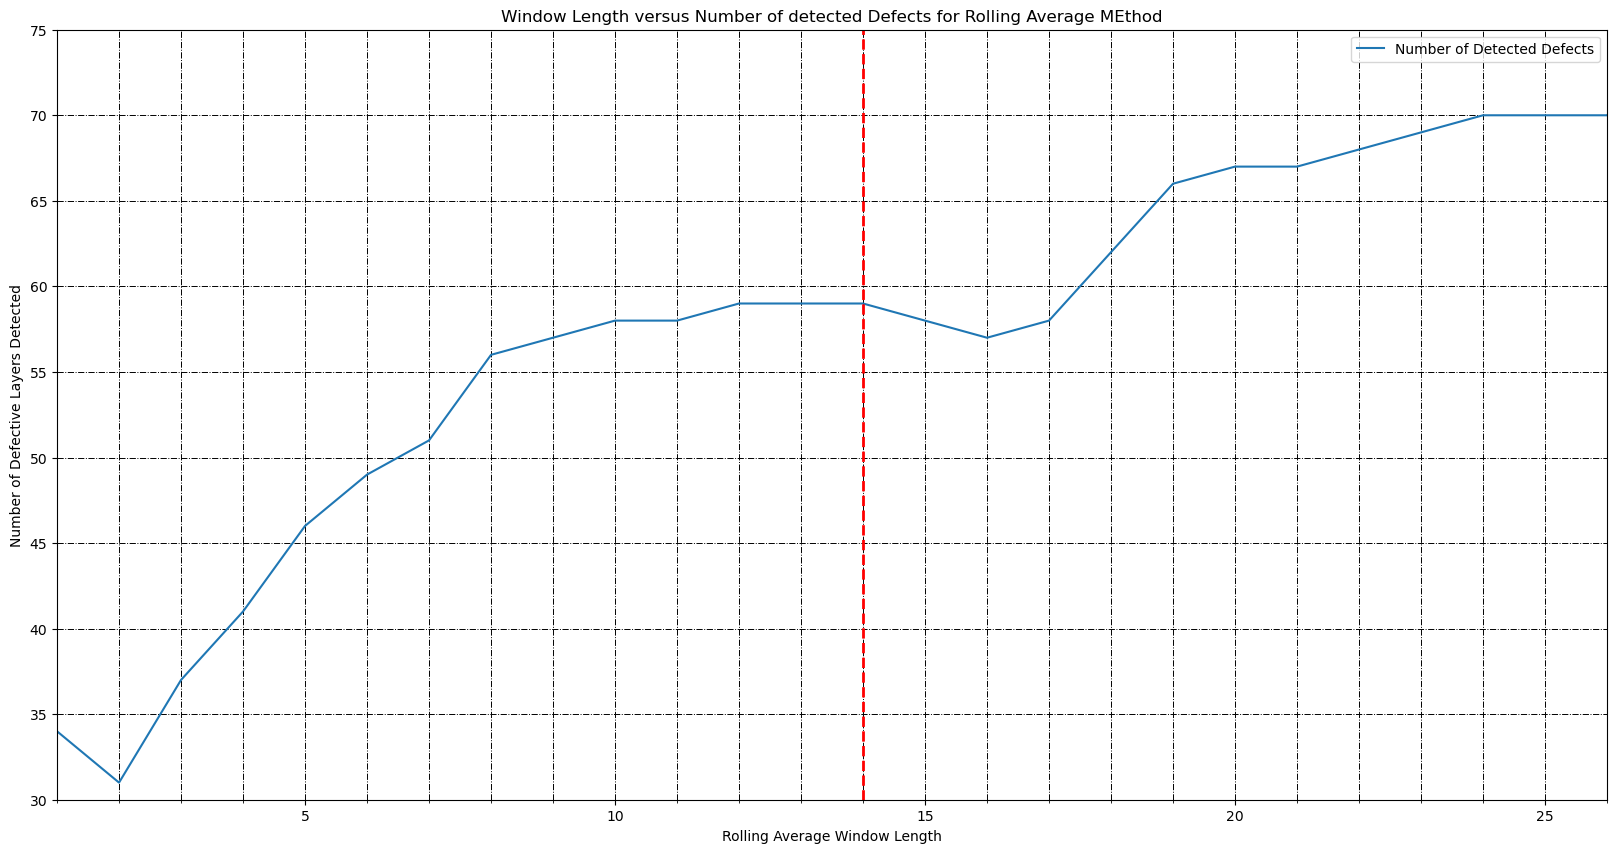

In [20]:
ax = plt.gca()
WLDataframe.plot(x='Window Length', y=['Number of Detected Defects'], kind="line", ax= ax, figsize=(20,10))
ml = MultipleLocator(1)
ax.xaxis.set_minor_locator(ml)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
ax.yaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
plt.ylabel('Number of Defective Layers Detected')
plt.xlabel('Rolling Average Window Length')
plt.title('Window Length versus Number of detected Defects for Rolling Average MEthod')
plt.axvline(x=14, linestyle = 'dashed',color = 'r', linewidth = 2)
plt.axis([1,26,30,75])


We can see from the above, that a Window Size of 14 has converged to detect 58 defective layers in the Centre Sample. What we need to do now is to check what layers were classed as anomalies. 

Luckily for us, we have a neat little DataFrame with the Layer ID's classed as anomalous for each Window Length. Amazing. We now just need to overlay this onto our Percentage Deviation, for a window length of 14 to see what we've got. 

In [21]:
Anomaly_Indices.tail(5)

,PD Signal Outlier 1,PD Signal Outlier 2,PD Signal Outlier 3,PD Signal Outlier 4,PD Signal Outlier 5,PD Signal Outlier 6,PD Signal Outlier 7,PD Signal Outlier 8,PD Signal Outlier 9,PD Signal Outlier 10,...,PD Signal Outlier 20,PD Signal Outlier 21,PD Signal Outlier 22,PD Signal Outlier 23,PD Signal Outlier 24,PD Signal Outlier 25,PD Signal Outlier 26,PD Signal Outlier 27,PD Signal Outlier 28,PD Signal Outlier 29
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,765.0,764.0,766
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,767.0,768.0,769
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,765.0,765
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,769.0,764
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,770


In [22]:
Anomalies = pd.DataFrame(PD1.loc[[int(i) for i in Anomaly_Indices['PD Signal Outlier 14'] if i > 0]]['Percentage Deviation'])
Anomalies

,Percentage Deviation
Layer ID,
706,8.830
705,6.285
707,9.706
704,6.784
708,7.560
703,-1.083
709,7.901
702,3.495
710,4.136


Text(0.5, 1.0, ' GESD Anomalies detected for Rolling Average Method for Window Length  = 14')

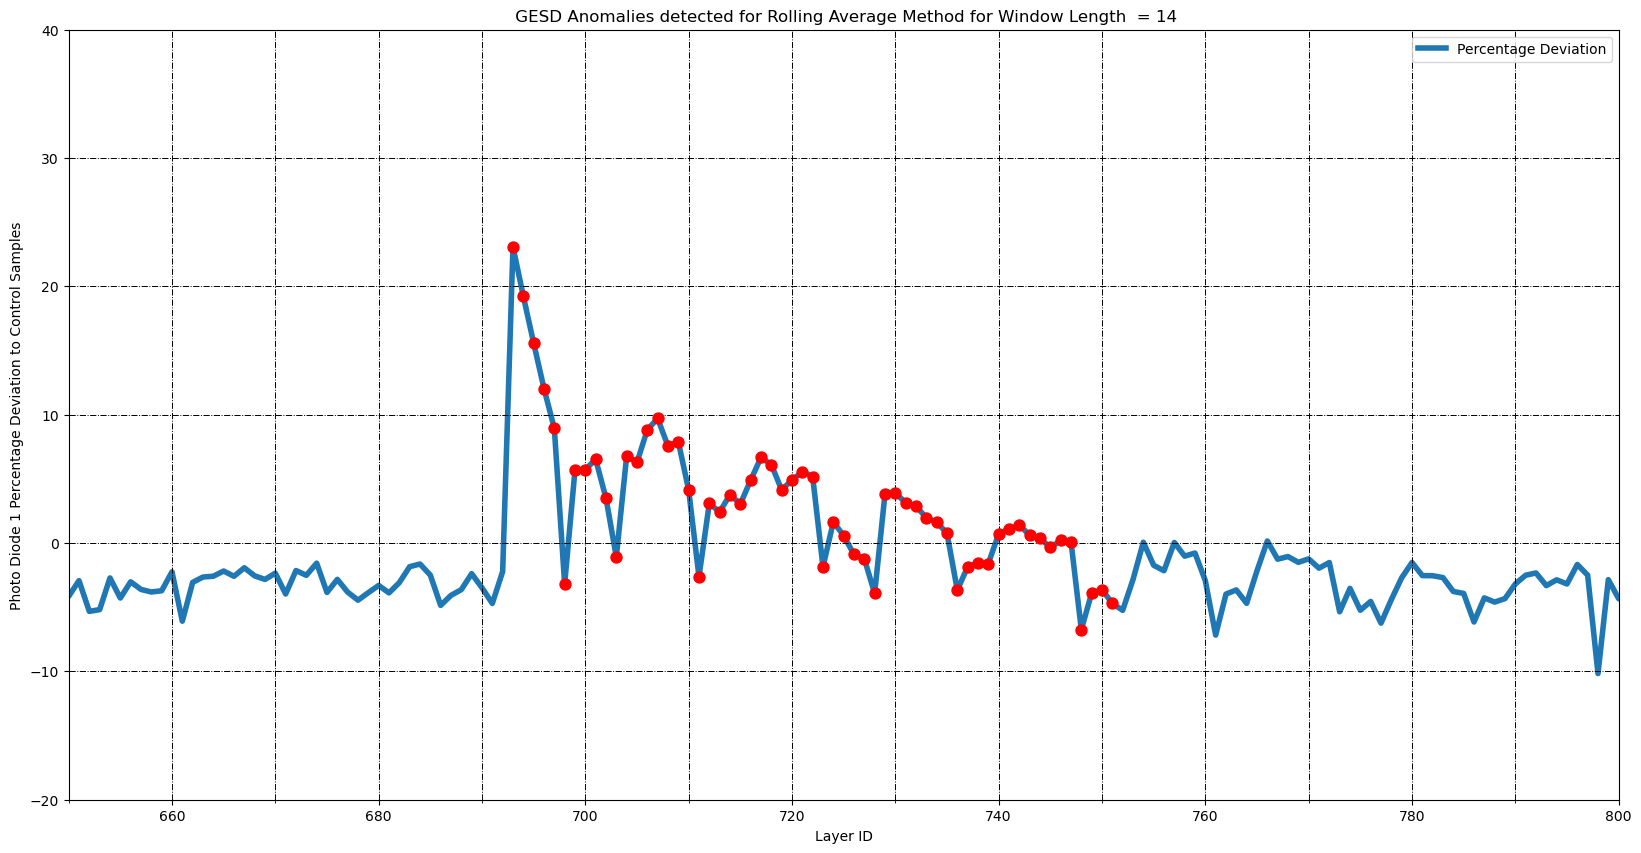

In [23]:
ax = plt.gca()
Anomalies = Anomalies.reset_index()
Anomalies.plot(x='Layer ID', y=['Percentage Deviation'], kind="scatter", ax= ax, s = 250, figsize=(20,10), color = 'r', marker = '.', zorder = 2)
PD1.reset_index().plot(x='Layer ID', y=['Percentage Deviation'], kind="line", ax= ax, figsize=(20,10), linewidth  = 4, zorder = 1 )
ml = MultipleLocator(10)
ml1 = MultipleLocator(10)
ax.xaxis.set_minor_locator(ml)
ax.yaxis.set_minor_locator(ml1)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
ax.yaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
plt.axis([650,800,-20,40])
plt.legend()
plt.ylabel('Photo Diode 1 Percentage Deviation to Control Samples')
plt.title(' GESD Anomalies detected for Rolling Average Method for Window Length  = 14')

Holy smokes look at that. We have succesfully detected Anomalous signals in the in-process monitoring data, in the known layers where the tear occured using signal processing and the GESD. Not to overhype this but this could be the single greatest series of events in the history of the world. 

But wait there's one final thing to check out. Let's check if an alternate signal smoothening method can be used to detect more anomalous layers. The reasoning behind this, is that having looked at the physical tear in the piece, we know the tear probably extends a bit closer to layer 800. 

Having done a bit of d'googling, the Savitsky-Golay interpolation method seems a good shout for a signal smoothening technique. Let's try that in place of the rolling average method, and see if we can detect more anomalies!

Just some info on the SG method. This method is commonly used to remove noise from nois-y signals. This method, uses odd window lengths. This is to ensure an even distribution of points are included wither side of the point in question. Also important to note here, rather than each point being the average of the say, 3 adjacent data points, the x-aaxis is split into # of points / window size intervals. 

A polynomial, of chosen degree is then fitted to each window. Parameter weights are adjusted to minimise residuals between interpolated values and true values. Boundary conditions are also important in this method, often with function values being set to 0 at these boundaries. 

In [24]:
from scipy.signal import savgol_filter #Importing our new filter!

In [25]:
testinglist_savgol = []
NDetected_savgol = []
Rollingavg_savgol = []
#Now to create a Dataframe for the WL of rolling average vs #defects detected
WLDataframe_savgol = pd.DataFrame()
Anomaly_Indices_savgol = {}

#Note, we're only using odd numbers here for the window. Also, since we're going with a third order polynomial for the Savgol Filter, we have to start
#the window size at 5, or the imported filter will throw an error
for i in range (5,30,2):
    testinglist_savgol.clear()
    RollingPerDevC_savgol = PD1['Percentage Deviation'].copy()
    RollingPerDevC_savgol = pd.DataFrame(RollingPerDevC_savgol)
    RollingPerDevC_savgol['Percentage Deviation'] = savgol_filter(np.array(RollingPerDevC_savgol['Percentage Deviation']), i, 3)
    RollingPerDevC_savgol = RollingPerDevC_savgol.dropna()
    array_savgol = RollingPerDevC_savgol['Percentage Deviation'].to_numpy()
    testinglist_savgol = ESD_Test(array_savgol, 0.05, 100)
    NDetected_savgol.append(len(testinglist_savgol))
    Rollingavg_savgol.append(i)
    ynew_savgol = []
    for z in testinglist_savgol:
        if z in RollingPerDevC_savgol.values:
            ynew_savgol.append(RollingPerDevC_savgol[RollingPerDevC_savgol['Percentage Deviation']== z ].index.values)
    DefectDataFramePer_savgol = pd.DataFrame(ynew_savgol, testinglist_savgol)
    Column_Name = 'PD Signal Outlier ' + str(i)
    Anomaly_Indices_savgol[Column_Name] = pd.Series(ynew_savgol).astype(int)
WLDataframe_savgol['Window Length'] = Rollingavg_savgol 
WLDataframe_savgol['Number of Detected Defects'] = NDetected_savgol
Anomaly_Indices_savgol = pd.DataFrame(Anomaly_Indices_savgol)
NDetected_savgol.clear()
Rollingavg_savgol.clear()
WLDataframe_savgol.head(5)

,Window Length,Number of Detected Defects
0,5,30
1,7,37
2,9,44
3,11,45
4,13,44


(1.0, 26.0, 30.0, 75.0)

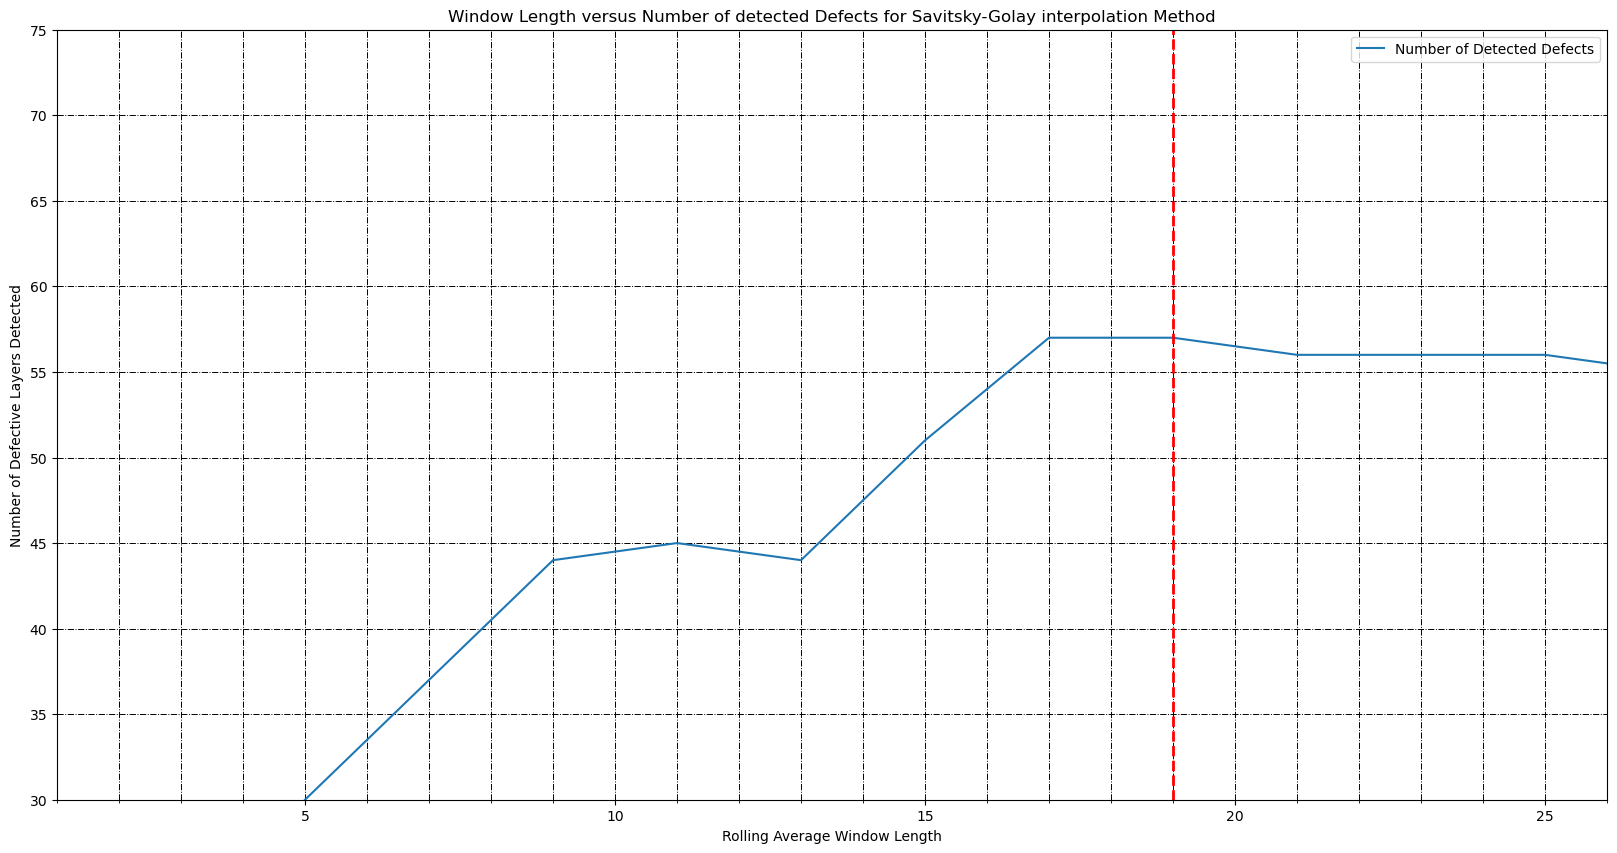

In [26]:
ax = plt.gca()
WLDataframe_savgol.plot(x='Window Length', y=['Number of Detected Defects'], kind="line", ax= ax, figsize=(20,10))
ml = MultipleLocator(1)
ax.xaxis.set_minor_locator(ml)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
ax.yaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
plt.ylabel('Number of Defective Layers Detected')
plt.xlabel('Rolling Average Window Length')
plt.title('Window Length versus Number of detected Defects for Savitsky-Golay interpolation Method')
plt.axvline(x=19, linestyle = 'dashed',color = 'r', linewidth = 2)
plt.axis([1,26,30,75])


In [27]:
Anomalies_savgol = pd.DataFrame(PD1.loc[[int(i) for i in Anomaly_Indices_savgol['PD Signal Outlier 19'] if i > 0]]['Percentage Deviation'])
Anomalies_savgol.head(5)

,Percentage Deviation
Layer ID,
696,12.040
695,15.583
697,8.932
698,-3.200
694,19.235


Text(0.5, 1.0, ' GESD Anomalies detected for Savitsky-Golay Method for Window Length  = 19')

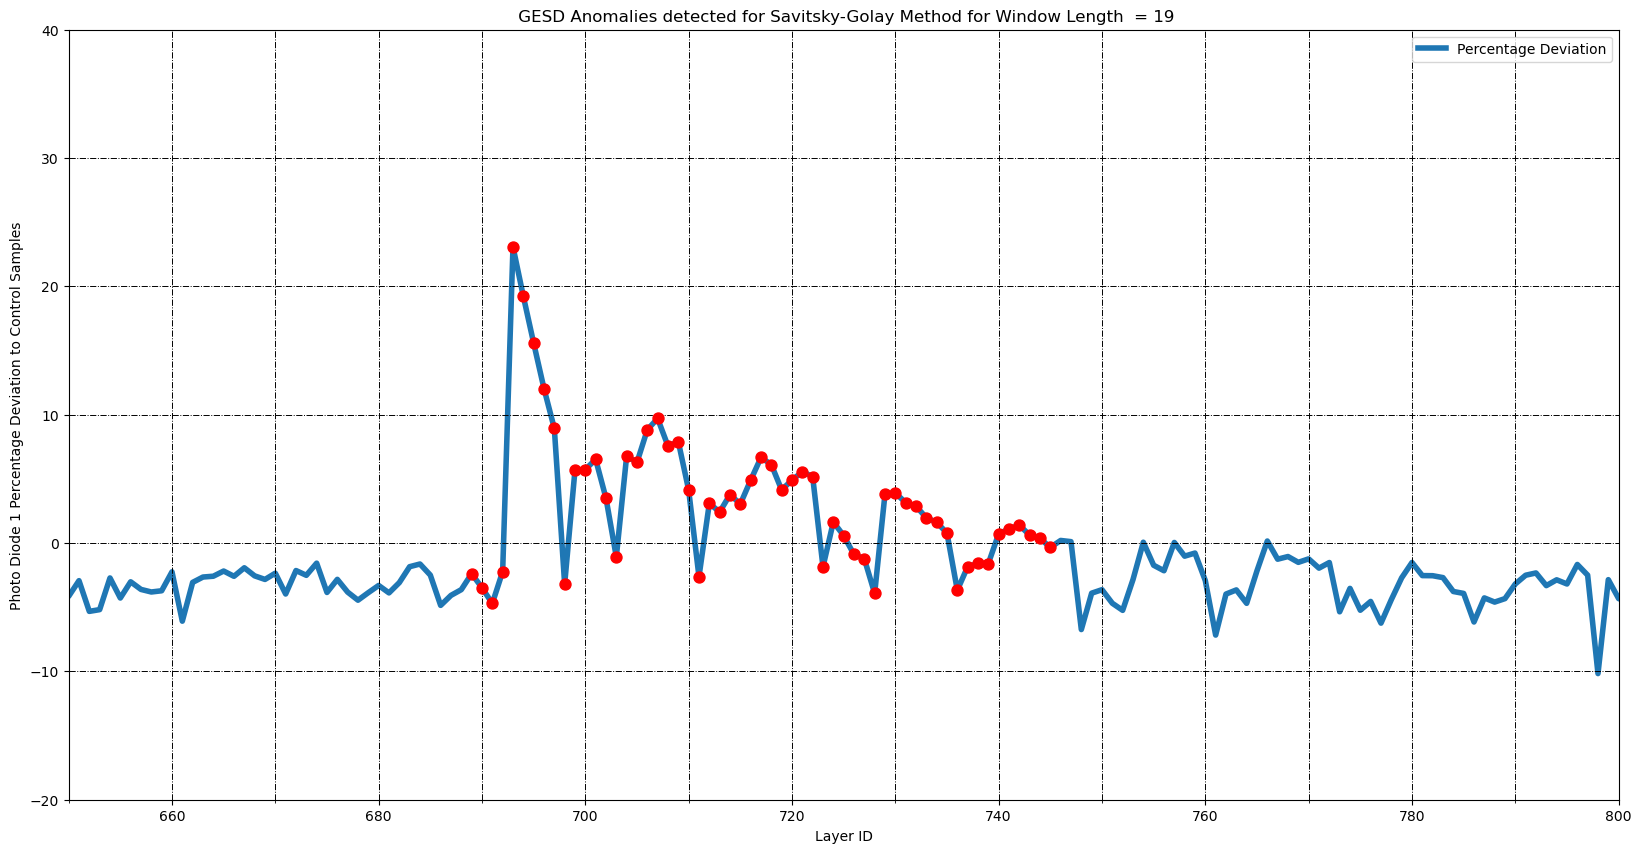

In [28]:
ax = plt.gca()
Anomalies_savgol = Anomalies_savgol.reset_index()
Anomalies_savgol.plot(x='Layer ID', y=['Percentage Deviation'], kind="scatter", ax= ax, s = 250, figsize=(20,10), color = 'r', marker = '.', zorder = 2)
PD1.reset_index().plot(x='Layer ID', y=['Percentage Deviation'], kind="line", ax= ax, figsize=(20,10), linewidth  = 4, zorder = 1 )
ml = MultipleLocator(10)
ml1 = MultipleLocator(10)
ax.xaxis.set_minor_locator(ml)
ax.yaxis.set_minor_locator(ml1)
ax.xaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
ax.yaxis.grid(which="both", color='k', linestyle='-.', linewidth=0.7)
plt.axis([650,800,-20,40])
plt.legend()
plt.ylabel('Photo Diode 1 Percentage Deviation to Control Samples')
plt.title(' GESD Anomalies detected for Savitsky-Golay Method for Window Length  = 19')

In [29]:
print(f'Using Centred Rolling average we detected {len(Anomalies)} anomalies whereas with Savitsky-Golay we detected {len(Anomalies_savgol)} anomalies!')

Using Centred Rolling average we detected 59 anomalies whereas with Savitsky-Golay we detected 57 anomalies!


OK, so detected an additional 2 anomalies with the Centred Rolling Average. Also the SG using a third order interpolating polynomial method picked up 3 anomalies pre-tear, which we don't want. We'll shtick to the Centred Moving Average!

# Conclusions

That was a nice project. We were able to successfully apply some signal processing methods, investigate their affects on the signals, as well as their affect on the number of detected Anomalies. 

We also had to deal with the fact that we initially had a **LOT** of data, and we had to attempt to reduce down the amount of what we had. All in all, the GESD is a useful way of detecting anomalies in a 1 dimensional dataset. If we had to use multidimensional data, another method would need to be used, something like the STRAY algorithm. 